# Biological data preparation

Authors: Aleksandr Koshkarov and Nadia Tahiri

**Abstract**

This pipeline introduces a methodology for constructing biologically meaningful datasets of phylogenetic trees with branch lengths, defined across various overlapping sets of taxa. Using comprehensive biological data, the methodology ensures control over the degree of overlap between species subsets, allowing for the creation of datasets with overlap levels ranging from 10\% to 90\%. These datasets are well suited for supertree construction, phylogenetic comparisons, and testing algorithms that handle trees with partial overlap. The datasets prepared with this pipeline for amphibians, birds, mammals, and sharks, publicly available on GitHub, provide a source for researchers to evaluate phylogenetic metrics, explore evolutionary relationships, and validate algorithms in supertree methodologies. Additionally, the described approach offers the flexibility to obtain customized datasets based on specific species of interest and dataset size, extending its utility to diverse evolutionary and phylogenetic research projects.

The following algorithm outlines the methodology for preparing phylogenetic tree datasets with varying levels of overlap. It describes the key steps involved in selecting species, calculating overlap levels, and generating overlapping subsets of species, which are then used to retrieve phylogenetic trees from the VertLife tool. The process ensures that each subset meets the desired overlap criteria and that the final datasets are formatted and ready for further analysis.

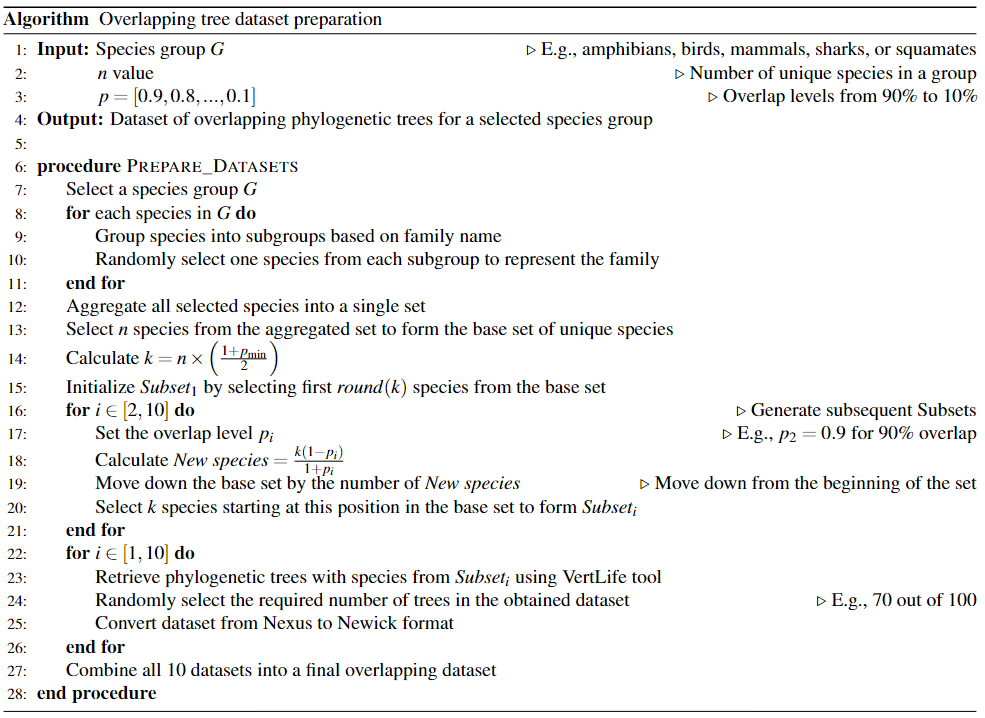

**Note:** all relevant files are located here: https://github.com/tahiri-lab/KNCL/tree/main/data/data-pipeline

### **Step 1.** Creation of subsets of species

The creation of subsets of species is based on an all-species list. Make sure there is an 'all_species_lists.csv' file in the script folder.

In [2]:
import pandas as pd
import random

# Load the data from the uploaded CSV file
file_path = '/content/all_species_lists.csv'
data = pd.read_csv(file_path)

# Extract the taxa for each group
amphibians = data['Amphibians'].dropna().tolist()
birds = data['Birds'].dropna().tolist()
mammals = data['Mammals'].dropna().tolist()
sharks = data['Sharks'].dropna().tolist()
squamates = data['Squamates'].dropna().tolist()

# Function to randomly select one species from each subgroup
def select_one_per_subgroup(species_list):
    subgroups = {}
    for species in species_list:
        subgroup = species.split()[0]  # Assume the first word represents the subgroup
        if subgroup not in subgroups:
            subgroups[subgroup] = species
    return list(subgroups.values())

# Select one species per subgroup for each group
selected_amphibians = select_one_per_subgroup(amphibians)
selected_birds = select_one_per_subgroup(birds)
selected_mammals = select_one_per_subgroup(mammals)
selected_sharks = select_one_per_subgroup(sharks)
selected_squamates = select_one_per_subgroup(squamates)

# Function to randomly select k species from the list
def select_k_species(species_list, k):
    return random.sample(species_list, k)


 #### Specify how many species (*n*) you need for each group.

In [3]:
# Randomly select the desired number of species from each group
final_amphibians = select_k_species(selected_amphibians, 120)
final_birds = select_k_species(selected_birds, 42)
final_mammals = select_k_species(selected_mammals, 105)
final_sharks = select_k_species(selected_sharks, 95)
final_squamates = select_k_species(selected_squamates, 80)

# Create a DataFrame to save the results
result_df = pd.DataFrame({
    'Amphibians': pd.Series(final_amphibians),
    'Birds': pd.Series(final_birds),
    'Mammals': pd.Series(final_mammals),
    'Sharks': pd.Series(final_sharks),
    'Squamates': pd.Series(final_squamates)
})

# Save the results to a CSV file
output_file = '/content/selected_species.csv'
result_df.to_csv(output_file, index=False)

Having selected the species, we can proceed to create 10 overlapping subsets for each species group.

Instructions:
1. **Input CSV File**: The script expects an input file named `selected_species.csv`, where each column contains species names, and the first row contains the group name.
2. **Process**: The script calculates *k* (the size of subsets) for each group and generates 10 overlapping subsets, saving them to a CSV file for each group.
3. **Output**: CSV files for each group containing the 10 subsets.

In [ ]:
import pandas as pd
import math

# Function to calculate n for a given k
def calculate_n_for_k(k, p_values=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]):
    n = k  # Start with k species in the first subset
    previous_new_species = 0  # Track the new species in the previous step
    for p in p_values:
        # Calculate the number of common species
        common_species = (2 * k * p) / (1 + p)
        rounded_common_species = round(common_species)
        new_species = k - rounded_common_species
        actual_new_species = new_species - previous_new_species
        n += math.ceil(actual_new_species)
        previous_new_species = new_species
    return int(n)

# Function to find k from a given n
def find_k_from_n(n, max_k=1000, p_values=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]):
    for k in range(1, max_k + 1):
        calculated_n = calculate_n_for_k(k, p_values)
        if calculated_n >= n:
            return k
    return None

# Function to generate overlapping subsets
def create_overlapping_subsets(df, p_values=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]):
    for group in df.columns:
        species_list = df[group].dropna().tolist()
        n = len(species_list)

        # Calculate the subset size k
        k = find_k_from_n(n)
        if k is None:
            print(f"Could not find a valid k for group {group}")
            continue

        # Create subsets
        subsets = {f"Subset {i}": [] for i in range(1, 11)}
        start_index = 0  # Start index remains fixed

        # Start with the first subset
        subsets['Subset 1'] = species_list[start_index:start_index + k]
        current_position = start_index + k  # Update the current position to move down the list

        for i, p in enumerate(p_values, start=2):
            # Calculate common and new species
            common_species = round((2 * k * p) / (1 + p))
            new_species = k - common_species

            # Select k species starting from start_index + new_species
            subset_start = start_index + int(new_species)
            subset_species = species_list[subset_start: subset_start + k]

            subsets[f"Subset {i}"] = subset_species

            # Update the current position for the next subset
            current_position = subset_start + k

        # Pad all subsets to ensure they are the same length
        max_len = len(species_list)
        for key in subsets:
            subsets[key] += [None] * (max_len - len(subsets[key]))  # Pad with None values if necessary

        # Save as CSV
        output_df = pd.DataFrame(subsets)
        output_file = f"{group}_overlapping_subsets.csv"
        output_df.to_csv(output_file, index=False)
        print(f"Saved file for {group}: {output_file}")

You may have your own set of species for one or more groups. In this case, save them in a csv file named `selected_species.csv`, where the first row specifies the species group followed by a list of selected species (make sure your species are present in the list of all species `all_species_lists.csv`).


In [ ]:
# Load your CSV file
df = pd.read_csv('selected_species.csv')

# Run the script
create_overlapping_subsets(df)

Saved file for Amphibians: Amphibians_overlapping_subsets.csv
Saved file for Birds: Birds_overlapping_subsets.csv
Saved file for Mammals: Mammals_overlapping_subsets.csv
Saved file for Sharks: Sharks_overlapping_subsets.csv
Saved file for Squamates: Squamates_overlapping_subsets.csv


#### Visualize pairwise overlap between subsets to see preliminary results, if necessary

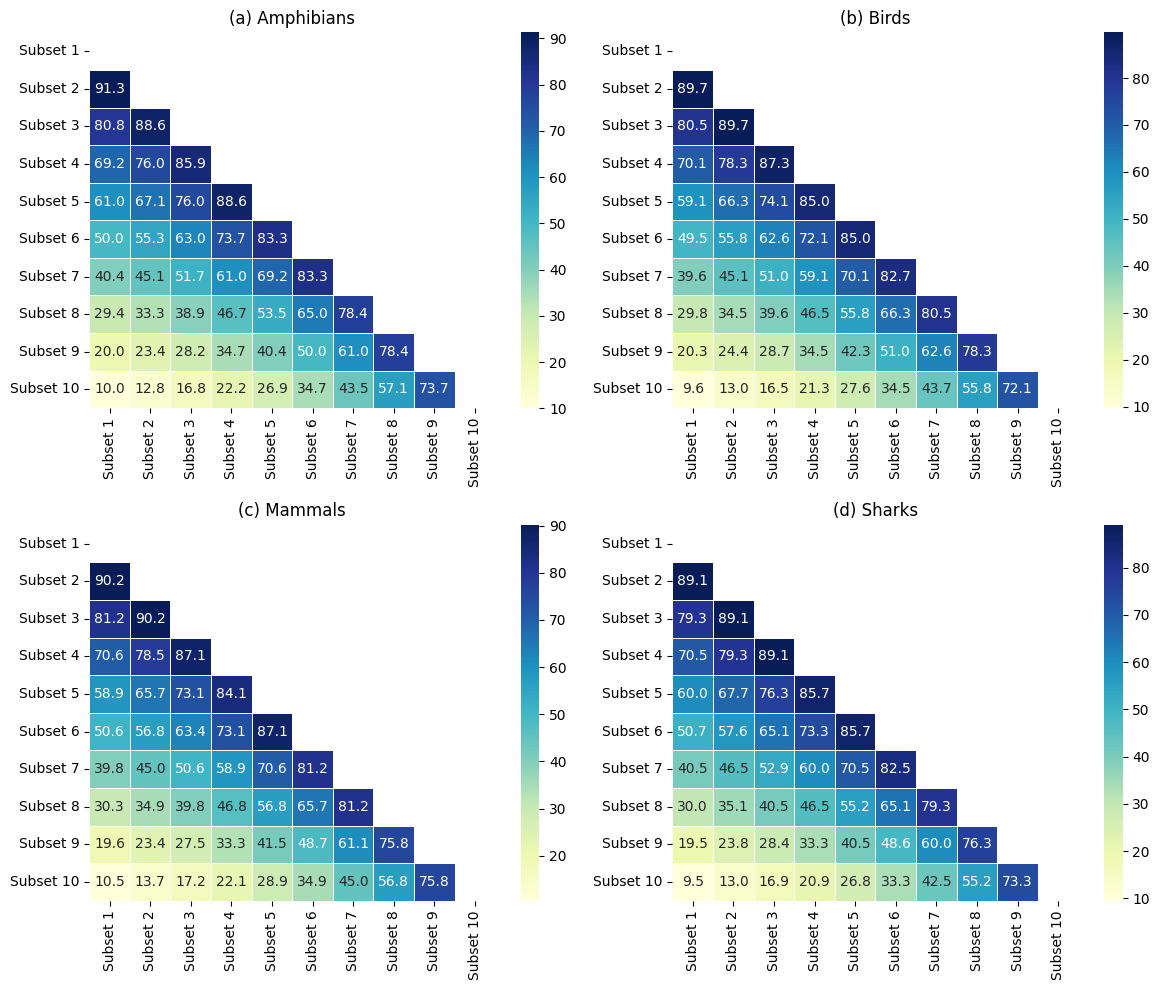

In [ ]:
# Example of 4 groups

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load data and calculate overlap levels
def calculate_overlap(df):
    groups = df.columns
    group_elements = {group: set(df[group].dropna()) for group in groups}
    overlap_table = pd.DataFrame(index=groups, columns=groups)

    def calculate_overlap_percentage(set1, set2):
        intersection = set1.intersection(set2)
        union = set1.union(set2)
        if len(union) == 0:  # Avoid division by zero
            return 0
        return len(intersection) / len(union) * 100

    # Calculate the overlap percentages
    for group1 in groups:
        for group2 in groups:
            overlap_table.loc[group1, group2] = calculate_overlap_percentage(group_elements[group1], group_elements[group2])

    return overlap_table.astype(float)

# Load CSV files for Amphibians, Birds, Mammals, and Sharks
amphibians_df = pd.read_csv('Amphibians_overlapping_subsets.csv')
birds_df = pd.read_csv('Birds_overlapping_subsets.csv')
mammals_df = pd.read_csv('Mammals_overlapping_subsets.csv')
sharks_df = pd.read_csv('Sharks_overlapping_subsets.csv')

# Calculate overlap tables
amphibians_overlap = calculate_overlap(amphibians_df)
birds_overlap = calculate_overlap(birds_df)
mammals_overlap = calculate_overlap(mammals_df)
sharks_overlap = calculate_overlap(sharks_df)

# Create a mask for the upper triangle
def create_mask(table):
    return np.triu(np.ones_like(table, dtype=bool))

# Create the grid of heatmaps (2x2)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot heatmaps for each group
sns.heatmap(amphibians_overlap, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=.5, mask=create_mask(amphibians_overlap), ax=axes[0, 0])
axes[0, 0].set_title("(a) Amphibians")

sns.heatmap(birds_overlap, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=.5, mask=create_mask(birds_overlap), ax=axes[0, 1])
axes[0, 1].set_title("(b) Birds")

sns.heatmap(mammals_overlap, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=.5, mask=create_mask(mammals_overlap), ax=axes[1, 0])
axes[1, 0].set_title("(c) Mammals")

sns.heatmap(sharks_overlap, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=.5, mask=create_mask(sharks_overlap), ax=axes[1, 1])
axes[1, 1].set_title("(d) Sharks")

# Adjust layout
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('overlap_heatmaps_grid.png')
#plt.savefig('overlap_heatmaps_grid.pdf') # uncomment if you want to save it as a pdf file
#plt.savefig('overlap_heatmaps_grid.svg') # uncomment if you want to save it as a svg file

# Show the plot
plt.show()


These overlapping subsets are then used to retrieve phylogenetic trees from the vertlife.org service (https://vertlife.org/phylosubsets/). This data can be obtained manually using the mentioned website or this process can be automated in the next step.

### **Step 2.** Data retrieval

In this script you need to specify your e-mail address. This address is used to receive links to the prepared data.

In [ ]:
# install required libraries

!pip install selenium
!pip install selenium webdriver-manager
!apt-get update
!apt install chromium-chromedriver

Data retrieving

In [7]:
import os
import time
import zipfile
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import shutil

# Mapping group names to the value attributes used on the webpage
GROUP_MAPPING = {
    "amphibians": "amphibiantree",
    "birds": "birdtree",
    "mammals": "mammaltree",
    "sharks": "sharktree",
    "squamates": "squamatetree"
}

def setup_driver():
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--remote-debugging-port=9222")
    chrome_options.add_argument("--window-size=1920x1080")

    driver = webdriver.Chrome(options=chrome_options)
    return driver

def clean_folder(folder_name):
    """
    Delete all contents in the folder if it exists.
    """
    if os.path.exists(folder_name):
        print(f"Cleaning folder: {folder_name}")
        shutil.rmtree(folder_name)  # Remove the folder and its contents
        os.makedirs(folder_name)  # Recreate an empty folder
    else:
        os.makedirs(folder_name)  # Create the folder if it doesn't exist

def submit_tree_request(driver, species_list, email, group):
    """
    Submit a tree request and capture job ID from the webpage.
    """
    driver.get('https://vertlife.org/phylosubsets/')

    try:
        # Handle radio button selection for species group
        if group.lower() != "amphibians":  # Amphibians is selected by default
            print(f"Selecting species group: {group}")
            group_value = GROUP_MAPPING.get(group.lower())
            if group_value:
                group_radio_button = WebDriverWait(driver, 30).until(
                    EC.element_to_be_clickable((By.XPATH, f"//input[@type='radio' and @value='{group_value}']"))
                )
                group_radio_button.click()
            else:
                print(f"Group {group} not found in the mapping.")
        else:
            print("Skipping species group selection since Amphibians is the default.")

        # Paste species into the textarea (line by line, no commas)
        species_textarea = driver.find_element(By.ID, 'selected')
        species_textarea.clear()
        species_textarea.send_keys('\n'.join(species_list))

        print(f"Email being used: {email}")
        # Enter email address
        email_input = driver.find_element(By.ID, 'email')
        email_input.clear()
        email_input.send_keys(email)

        print("Submitting tree request...")
        # Click 'Get Trees'
        get_trees_button = driver.find_element(By.ID, 'btnGetTrees')
        get_trees_button.click()

        # Wait for job ID
        print("Waiting for Job ID...")
        job_id_element = WebDriverWait(driver, 60).until(
            EC.presence_of_element_located((By.XPATH, "//div[@id='status']//strong"))
        )
        job_id = job_id_element.text.strip()  # Extract the job ID
        print(f"Job ID: {job_id}")
        return job_id

    except Exception as e:
        print(f"Error during tree request: {str(e)}")
        return None


def download_zipfile_using_job_id(job_id, folder_name, max_retries=20):
    """
    Directly construct the URL from the job ID and download the file, retry up to max_retries if it fails.
    """
    download_url = f"https://data.vertlife.org/pruned_treesets/{job_id}/{job_id}.zip"
    print(f"Downloading from: {download_url}")

    retries = 0
    while retries < max_retries:
        response = requests.get(download_url)

        if response.status_code == 200:
            zip_filename = os.path.join(folder_name, f"{job_id}.zip")

            # Save the zip file
            with open(zip_filename, 'wb') as f:
                f.write(response.content)

            try:
                with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                    print(f"Extracting files from {zip_filename}...")
                    for file in zip_ref.namelist():
                        # Rename extracted files using job_id to ensure uniqueness
                        file_extension = os.path.splitext(file)[1]  # Get the file extension (e.g., .nex)
                        new_file_name = f"{job_id}{file_extension}"  # Construct new file name using job_id
                        target_path = os.path.join(folder_name, new_file_name)

                        # Extract and rename the file
                        zip_ref.extract(file, folder_name)
                        os.rename(os.path.join(folder_name, file), target_path)
                        print(f"Extracted: {target_path}")
            except zipfile.BadZipFile:
                print(f"Error: {zip_filename} is not a valid zip file.")
            return True
        else:
            retries += 1
            print(f"Failed to download from {download_url}. Status code: {response.status_code}. Retrying... ({retries}/{max_retries})")
            time.sleep(30)
    print(f"Failed to download file after {max_retries} attempts.")
    return False

def automate_process(input_file, email):
    # Extract group name dynamically from the input file name
    group_name = os.path.basename(input_file).split('_')[0]
    print(f"Group Name: {group_name}")

    # Create and clean folder for the group
    folder_name = f"{group_name}_nexus"
    clean_folder(folder_name)  # Clean the folder before starting the process

    # Load the input data (species subsets)
    df = pd.read_csv(input_file)

    job_ids = {}

    # Step 1: Request trees and collect job IDs
    for subset_name in df.columns:
        success = False
        retries = 0
        while not success and retries < 15:
            try:
                print(f"Requesting trees for {subset_name}")
                species_list = df[subset_name].dropna().tolist()
                # Initialize the driver for each request
                driver = setup_driver()
                job_id = submit_tree_request(driver, species_list, email, group_name)
                driver.quit()  # Quit the driver after the request
                if job_id:
                    job_ids[subset_name] = job_id
                    success = True
                else:
                    print(f"Retrying {subset_name} due to missing job ID.")
                    retries += 1
                    time.sleep(20)
            except Exception as e:
                print(f"Exception during processing subset {subset_name}: {e}")
                retries += 1
                time.sleep(20)

        # Wait a bit before the next request
        time.sleep(10)

    # Added Delay Before Downloading Files
    print("Waiting for 60 seconds before starting downloads to ensure files are ready...")
    time.sleep(60)  # Wait for 60 seconds

    # Step 2: Download the results using the job ID
    for subset_name, job_id in job_ids.items():
        print(f"Processing download for {subset_name}")
        download_success = download_zipfile_using_job_id(job_id, folder_name)
        if not download_success:
            print(f"Failed to download trees for {subset_name}")
    driver.quit()

Make sure you enter your email in the appropriate field

In [ ]:
# Example for Amphibians
input_file = 'Amphibians_overlapping_subsets.csv' # specify the file for your group
email = '' # specify your email here
automate_process(input_file, email)

You can repeat the previous script for each group of interest (amphibians, birds, mammals, sharks, and squamates).

In [ ]:
# Example for Birds
input_file = 'Birds_overlapping_subsets.csv' # specify the file for your group
email = '' # specify your email here
automate_process(input_file, email)

In [ ]:
# Example for Mammals
input_file = 'Mammals_overlapping_subsets.csv' # specify the file for your group
email = '' # specify your email here
automate_process(input_file, email)

In [ ]:
# Example for Sharks
input_file = 'Sharks_overlapping_subsets.csv' # specify the file for your group
email = '' # specify your email here
automate_process(input_file, email)

### **Step 3.** Preparation of datasets

Once we have our datasets (10 subsets for each group), we need to reformat them from Nexus to Newick, randomly select the required number of trees from each subset, and merge all the files into one large dataset.

In [ ]:
!pip install biopython # library to work with phylogenetic trees

In [11]:
import os
import random
from Bio import Phylo

def convert_nexus_to_newick(nexus_file, t):
    """
    Convert trees from a Nexus file to Newick format, randomly select t trees.

    Args:
    - nexus_file (str): Path to the Nexus file.
    - t (int): Number of random trees to select.

    Returns:
    - A list of cleaned Newick-formatted trees.
    """
    # Parse the Nexus file
    trees = list(Phylo.parse(nexus_file, "nexus"))

    # Check if we have enough trees in the file
    if len(trees) < t:
        print(f"Warning: {nexus_file} has fewer than {t} trees. Selecting all available trees.")
        t = len(trees)

    # Randomly select t trees
    selected_trees = random.sample(trees, t)

    # Convert the selected trees to Newick format and clean up ':0.00000' at the end
    selected_newick_trees = []
    for tree in selected_trees:
        newick_str = tree.format('newick').strip()
        # Remove ':0.00000' or any ':<number>' before the final ';'
        if newick_str.endswith(":0.00000;"):
            newick_str = newick_str[:-9] + ';'
        selected_newick_trees.append(newick_str)

    return selected_newick_trees

def process_nexus_files(input_dir, output_file, t):
    """
    Process all Nexus files in the input directory, convert trees to Newick,
    randomly select t trees from each file, and combine them into one output file.

    Args:
    - input_dir (str): Directory containing the Nexus files.
    - output_file (str): Path to the final output file.
    - t (int): Number of random trees to select per file.
    """
    all_selected_trees = []

    # Loop through all .nex files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".nex"):
            nexus_file = os.path.join(input_dir, filename)
            selected_trees = convert_nexus_to_newick(nexus_file, t)
            all_selected_trees.extend(selected_trees)

    # Save all selected trees into one file without blank lines
    with open(output_file, 'w') as out_file:
        for tree in all_selected_trees:
            if tree:  # Ensure no blank lines
                out_file.write(tree + '\n')

    print(f"Saved {len(all_selected_trees)} Newick trees to {output_file}")

In [ ]:
# Example for Amphibians
input_dir = "/content/Amphibians_nexus/"  # Replace with the directory containing Nexus files
output_file = "overlapping_dataset_amphibians.txt"  # Path to the final combined output file
t = 55  # Set the number of random trees to select per file

# Run the script
process_nexus_files(input_dir, output_file, t)

Saved 550 Newick trees to overlapping_dataset_amphibians.txt


In [12]:
# Example for Birds
input_dir = "/content/Birds_nexus/"  # Replace with the directory containing Nexus files
output_file = "overlapping_dataset_birds.txt"  # Path to the final combined output file
t = 60  # Set the number of random trees to select per file

# Run the script
process_nexus_files(input_dir, output_file, t)

Saved 600 Newick trees to overlapping_dataset_birds.txt


In [ ]:
# Example for Mammals
input_dir = "/content/Mammals_nexus/"  # Replace with the directory containing Nexus files
output_file = "overlapping_dataset_mammals.txt"  # Path to the final combined output file
t = 50  # Set the number of random trees to select per file

# Run the script
process_nexus_files(input_dir, output_file, t)

Saved 500 Newick trees to overlapping_dataset_mammals.txt


In [ ]:
# Example for Sharks
input_dir = "/content/Sharks_nexus/"  # Replace with the directory containing Nexus files
output_file = "overlapping_dataset_sharks.txt"  # Path to the final combined output file
t = 45  # Set the number of random trees to select per file

# Run the script
process_nexus_files(input_dir, output_file, t)

Saved 450 Newick trees to overlapping_dataset_sharks.txt


With the raw data in the appropriate folders, it is possible to create many different sized subsets of data for each group of interest for research purposes (e.g., to test appropriate methods and algorithms).

Once you have the data, be sure to cite the source:

* **Amphibians**: Jetz, W., & Pyron, R. A. (2018). The interplay of past diversification and evolutionary isolation with present imperilment across the amphibian tree of life. Nature ecology & evolution, 2(5), 850-858.

* **Birds**: Jetz, W., Thomas, G. H., Joy, J. B., Hartmann, K., & Mooers, A. O. (2012). The global diversity of birds in space and time. Nature, 491(7424), 444-448.

* **Mammals**: Upham, N. S., Esselstyn, J. A., & Jetz, W. (2019). Inferring the mammal tree: species-level sets of phylogenies for questions in ecology, evolution, and conservation. PLoS biology, 17(12), e3000494.

* **Sharks**: Stein, R. W., Mull, C. G., Kuhn, T. S., Aschliman, N. C., Davidson, L. N., Joy, J. B., ... & Mooers, A. O. (2018). Global priorities for conserving the evolutionary history of sharks, rays and chimaeras. Nature ecology & evolution, 2(2), 288-298.

* **Squamates**: Tonini, J. F. R., Beard, K. H., Ferreira, R. B., Jetz, W., & Pyron, R. A. (2016). Fully-sampled phylogenies of squamates reveal evolutionary patterns in threat status. Biological Conservation, 204, 23-31.

Website: https://vertlife.org/data/


### Additional visualizations (optional)

In [ ]:
!pip install ete3 # library to work with phylogenetic trees

Number of trees: 700
Total number of unique species: 137


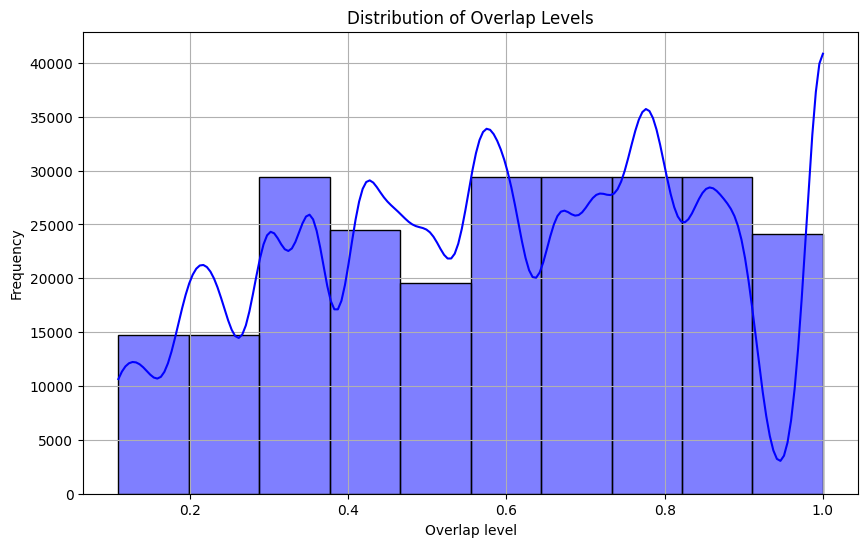

Average level of overlap: 0.5952
Number of unique pairs of trees: 244650
Number of unique pairs of trees with 100% overlap: 24150 or 9.87%


In [ ]:
from ete3 import Tree
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_name = 'overlapping_dataset_birds.txt' # choose your dataset
with open(file_name, 'r') as f:
    trees = [line.strip() for line in f if line.strip()]

# Step 1: Count the number of trees
num_trees = len(trees)
print(f'Number of trees: {num_trees}')

# Step 2: Extract unique species from all trees using ete3
all_species = set()
species_per_tree = []

for tree_str in trees:
    # Parse the tree using ete3
    tree = Tree(tree_str, format=1)
    # Extract the species (leaf names)
    species = set(leaf.name for leaf in tree)
    species_per_tree.append(species)
    all_species.update(species)

num_unique_species = len(all_species)
print(f'Total number of unique species: {num_unique_species}')

# Step 3: Calculate pairwise Jaccard coefficients
def jaccard_index(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0
    return intersection / union

# Get all unique pairs of trees (combinations)
pairwise_jaccard = []
pairs_with_full_overlap = 0

for tree1, tree2 in combinations(species_per_tree, 2):
    jaccard = jaccard_index(tree1, tree2)
    pairwise_jaccard.append(jaccard)

    # Count pairs with 100% overlap
    if jaccard == 1.0:
        pairs_with_full_overlap += 1

# Step 4: Visualization of overlap distribution
plt.figure(figsize=(10, 6))
sns.histplot(pairwise_jaccard, bins=10, kde=True, color='blue')
plt.title('Distribution of Overlap Levels')
plt.xlabel('Overlap level')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Step 5: Calculate the average overlap
average_overlap = sum(pairwise_jaccard) / len(pairwise_jaccard)
print(f'Average level of overlap: {average_overlap:.4f}')

# Step 6: Calculate the number of unique pairs of trees
num_pairs = (num_trees * (num_trees - 1)) // 2
print(f'Number of unique pairs of trees: {num_pairs}')

# Step 7: Output the number of pairs with 100% overlap
pairs_with_full_overlap_ratio = round((pairs_with_full_overlap / num_pairs)*100,2)
print(f'Number of unique pairs of trees with 100% overlap: {pairs_with_full_overlap} or {pairs_with_full_overlap_ratio}%')


## All four distributions in one place (for the case of 4 groups)

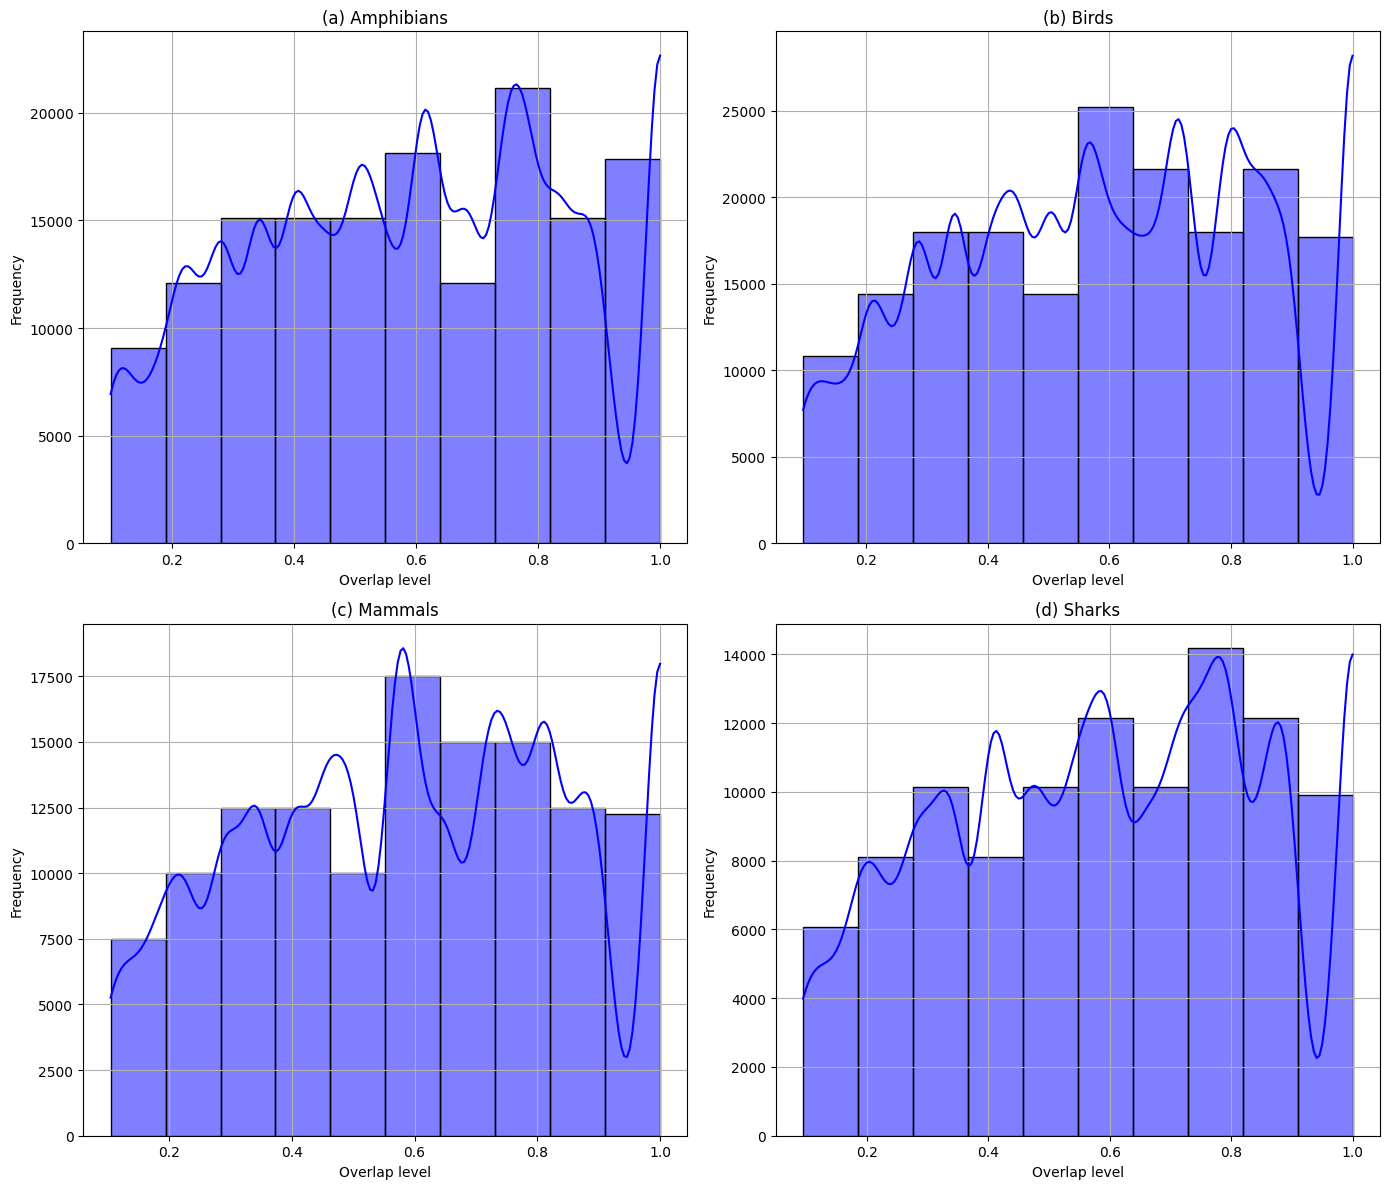

In [ ]:
from ete3 import Tree
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load and parse trees, calculate overlap levels, and return Jaccard coefficients
def analyze_dataset(file_name, dataset_name):
    with open(file_name, 'r') as f:
        trees = [line.strip() for line in f if line.strip()]

    # Step 1: Extract unique species from all trees using ete3
    species_per_tree = []
    for tree_str in trees:
        tree = Tree(tree_str, format=1)
        species = set(leaf.name for leaf in tree)
        species_per_tree.append(species)

    # Step 2: Calculate pairwise Jaccard coefficients
    def jaccard_index(set1, set2):
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        if union == 0:
            return 0
        return intersection / union

    pairwise_jaccard = []
    for tree1, tree2 in combinations(species_per_tree, 2):
        jaccard = jaccard_index(tree1, tree2)
        pairwise_jaccard.append(jaccard)

    return pairwise_jaccard, dataset_name

# List of datasets (specify your datasets here)
datasets = [
    ('overlapping_dataset_amphibians.txt', '(a) Amphibians'),
    ('overlapping_dataset_birds.txt', '(b) Birds'),
    ('overlapping_dataset_mammals.txt', '(c) Mammals'),
    ('overlapping_dataset_sharks.txt', '(d) Sharks')
]

# Create a 2x2 plot grid for visualizing the overlap levels
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Loop through datasets and analyze each
for i, (file_name, dataset_name) in enumerate(datasets):
    row, col = divmod(i, 2)  # For 2x2 grid layout

    # Get the overlap (Jaccard coefficients) for the dataset
    pairwise_jaccard, dataset_name = analyze_dataset(file_name, dataset_name)

    # Plot the histogram for each dataset in its respective subplot
    sns.histplot(pairwise_jaccard, bins=10, kde=True, color='blue', ax=axes[row, col])
    axes[row, col].set_title(f'{dataset_name}')
    axes[row, col].set_xlabel('Overlap level')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].grid(True)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('overlap_levels_comparison.png')
#plt.savefig('overlap_levels_comparison.pdf')
#plt.savefig('overlap_levels_comparison.svg')

# Show the plot
plt.show()
